In [1]:
import sys
import os


sys.path.append(os.path.join('..', '..', 'utils'))
sys.path.append(os.path.join('..', '..'))

import utils
import torch

from torchvision import datasets
import torchvision.transforms as T
import models

from conf import global_settings as settings
from utils_train import dataset_loader

c:\Users\nelso\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
utils.setup_seed(0)

In [3]:
training_loader, test_loader, perm = dataset_loader(
    'cifar10',
    settings.CIFAR10_TRAIN_MEAN,
    settings.CIFAR10_TRAIN_STD,
    num_workers = 4,
    batch_size = 32,
    shuffle=True,
    shuffle_pixels = True
)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
img = next(iter(training_loader))[0][0]

img.shape

torch.Size([3, 32, 32])

In [5]:
img_ordered = perm.ordenar(img.unsqueeze(0)).squeeze(0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


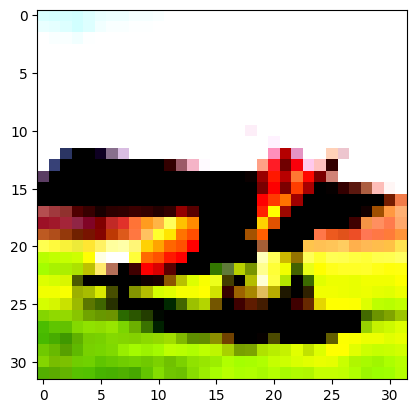

In [9]:
import matplotlib.pyplot as plt

plt.imshow(img_ordered.permute(1,2,0))

In [6]:
%pip install torchinfo

You should consider upgrading via the 'c:\Users\nelso\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [ ]:
import sys
import os

sys.path.append(os.path.join('..', '..', 'utils'))
sys.path.append(os.path.join('..', '..'))


from torchinfo import summary
from models import vgg_permuted
import utils

perm = utils.Permutar(32,1)

vgg = vgg_permuted.vgg16_bn_deformable(perm,2)

summary(vgg, input_size=(2, 3, 32, 32))

In [78]:
import sys
import os

sys.path.append(os.path.join('..', '..', 'utils'))
sys.path.append(os.path.join('..', '..'))

import torch
import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

my_tensor = torch.tensor([[1, 2, 3,4],
                       [5, 6,7,8],
                       [9,5,9,19],
                          [13,14,17,29]]).to(device).float()

my_tensor = my_tensor.unsqueeze(0).unsqueeze(0)

my_tensor = my_tensor.repeat(2,1,1,1)

perm = utils.Permutar(4,1)

my_tensor_permuted = perm.desordenar(my_tensor)

In [76]:
pool = utils.DeformMaxPool2d(4, perm, 3)
pool.new_perm.ordenar(pool(my_tensor_permuted))

tensor([[[[10.]]],


        [[[10.]]]])

In [12]:
perm.ordenar(result)

tensor([[[[ 6.,  8.],
          [14., 16.]]],


        [[[ 6.,  8.],
          [14., 16.]]]])

In [79]:
from torch import nn

m = nn.MaxPool2d(3)
m(my_tensor)

tensor([[[[9.]]],


        [[[9.]]]])

In [49]:
output = torch.load('output.pt')
output_deformed = torch.load('output_deformed.pt')

print(output.shape, output_deformed.shape)

output = output.squeeze()
output_deformed = output_deformed.squeeze()


torch.Size([64, 512, 1, 1]) torch.Size([64, 512, 1, 1])


In [47]:
output.shape, output_deformed.shape

(torch.Size([64, 512]), torch.Size([64, 512]))

In [26]:
output[0,0,0,0], output_deformed[0,0,0,0]

IndexError: index 1 is out of bounds for dimension 2 with size 1

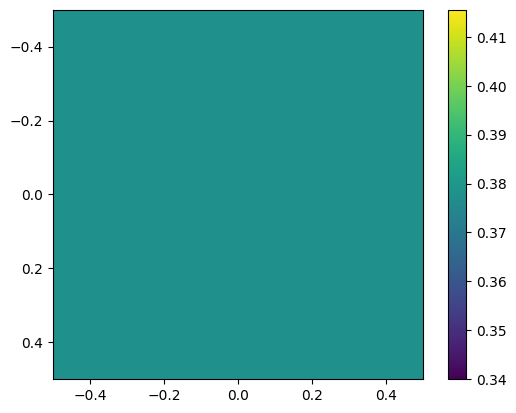

In [20]:
import matplotlib.pyplot as plt
plt.imshow(output[0,0,:,:].detach().numpy())
plt.colorbar()

In [16]:

output[0,0,0,0], output_deformed[0,0,0,0]

(tensor(0.3778), tensor(0.5105))